## Mirai 의 목적
- Making automated system which can earn money (size doesn't matter) for me.
- keeping track of my progress so that nothing goes away.

## Mirai 1.0 의 Capacity
- [ ] can load cc data automatically
- [ v ] can load cc data when asked
- [ v ] can process data to build model and predict next data
- [ ] can predict _ data with __ accuracy
- [ ] can sell
- [ ] can buy
- [ ] can earn _ in 1 day

## Mirai 1.0

### 0. Import Libraries

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import requests, json
from urllib.parse import quote
from numpy import array, argmax, array_equal
from random import randint

from sklearn.model_selection import train_test_split

from keras import backend, optimizers
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, TimeDistributed, RepeatVector
from keras.utils import to_categorical

In [17]:
from tqdm import *

In [7]:
dataset = load_data('XRP', 1, 10000)
print('Shape of the Data:',dataset.shape)

Shape of the Data: (10000, 11)


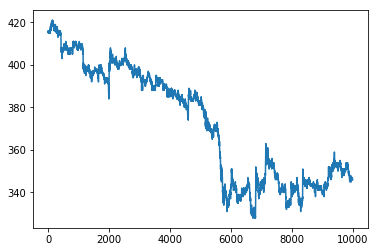

In [8]:
plt.plot(dataset[:,[6]].astype(float))

### 2. Set constant values / hyperparameters

In [12]:
col=[6] #closing price만 사용
input_seq = 5 #5개의 x를 넣으면 
output_seq = 1 #1개의 y가 나옴
hidden = 100
batch_size = 512
epoch = 10
#features = 1000

In [21]:
train, test = train_test_split(dataset, test_size=0.01)

In [29]:
meta, x_data, y_data = processor(train, col)

100%|██████████| 9895/9895 [00:00<00:00, 431572.89it/s]


In [ ]:
def define_model():
    return model

## TODO
- processor 에서 data가 한덩어리 아니고 x,y 나눠져서 들어가는 경우에 대한 처리 추가 (현재는 make_sequence가 중복데이터 넣도록 하드코딩)

In [6]:
def call_candle(currency, minutes, count, to=''):
    max_count = 100

    if count > max_count:
        iter_range = count // max_count
        iter_left = count % max_count
        total = []

        while iter_range:
            to_encoded = quote(to)
            URL = 'https://api.upbit.com/v1/candles/minutes/' + str(
                minutes) + '?market=KRW-' + currency + '&count=' + str(max_count) + '&to=' + to_encoded
            req = requests.get(URL)
            res = json.loads(req.text)

            iter_range -= 1
            to = res[-1]['candle_date_time_kst'] + '+09:00'
            total += res

        if iter_left > 0:
            to_encoded = quote(to)
            URL = 'https://api.upbit.com/v1/candles/minutes/' + str(
                minutes) + '?market=KRW-' + currency + '&count=' + str(iter_left) + '&to=' + to_encoded
            req = requests.get(URL)
            res = json.loads(req.text)
            total += res

        return total
    else:
        to_encoded = quote(to)
        URL = 'https://api.upbit.com/v1/candles/minutes/' + str(
            minutes) + '?market=KRW-' + currency + '&count=' + str(count) + '&to=' + to_encoded
        req = requests.get(URL)
        res = json.loads(req.text)
        res.reverse()

        return res
    
def load_data(currencies, mins, counts):
    #loading data
    data_origin = call_candle(currencies, minutes=mins , count=counts, to='2018-12-10T23:00:00+09:00')
    data_array = []
    for i in data_origin:
        data_array.append(list(i.values()))
    data = np.array(data_array)
    data = data[data[:,2].argsort()] #sort by time
    return data

def processor(data, col, scale=False, is_training=True, v=None):
    if is_training == True:
        v = {}
    x = {}
    
    #Missing Value 핸들링 : 각 값들을 median value로 채움
    #Scale = standard scaling을 사용, training의 값만으로 scaling의 기준점을 잡음
    if scale == True:
        for i in range(len(col)):
            if is_training == True:
                v[i] = get_metadata(data[:,col][:,i].astype(float))
            x[i] = scale_value(data[:,col][:,i].astype(float), v[i], scale_method='standard')
    else:
        for i in range(len(col)):
            x[i] = data[:,col][:,i].astype(float)
    
    x_val = np.transpose(np.array(list(x.values()))) 
    #x value를 (samples,1)의 shape로 리턴
    #데이터셋 중에 필요한 컬럼만 추출하여 scale 처리하면서 meta를 저장함
    
    def make_sequence(data_x, data_y, input_seq, output_seq):
        
        data_x_list = []
        data_y_list = []
        
        for i in tqdm(range(len(data_x) - (input_seq + output_seq - 1))):
            data_x_list.append(data_x[i:i + input_seq])
            data_y_list.append(data_y[i + input_seq:i + input_seq + output_seq])
        
        return np.array(data_x_list), np.array(data_y_list)

    
    x, y = make_sequence(x_val, x_val, input_seq, output_seq)

    return v, x, y